### Load libraries

In [12]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from itertools import islice
import torch
import os
import re
import wandb
from sklearn.preprocessing import StandardScaler
import pandas as pd 
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas
from gluonts.dataset.common import ListDataset
from tqdm.autonotebook import tqdm
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.pandas import PandasDataset
from lag_llama.gluon.estimator import LagLlamaEstimator

In [ ]:
torch.cuda.empty_cache()

## Load df: all the trajectories of sensor 14 from train_FD001

### Standardise both train_df and test_df using the mean and std of train_df

In [2]:
train_df = pd.read_csv(f'cmapss_data_fd001/train_14.csv', index_col=0)
test_df = pd.read_csv(f'cmapss_data_fd001/test_14.csv', index_col=0)

# train_df = pd.read_csv(f'cmapss_data_fd001/train_15.csv', index_col=0)
# test_df = pd.read_csv(f'cmapss_data_fd001/test_15.csv', index_col=0)

In [3]:
# calculate the overall average and overall std for training dataset and use it for standardising both train and test dataset
mean = round(train_df.mean().sum() / (len(train_df.mean())), 2) # 8146.19 
std = round(train_df.std().mean(), 2) # 11.90

train_df_std = (train_df - mean) / std
test_df_std = (test_df - mean) / std

train_data = [{"start": train_df_std.index[0], "target": train_df_std[i].values} for i in train_df_std.columns]
test_data = [{"start": test_df_std.index[0], "target": test_df_std[i].values} for i in test_df_std.columns]
train_ds = ListDataset(data_iter=train_data, freq='1s') # training dataset
test_ds = ListDataset(data_iter=test_data, freq='1s') # testing dataset

In [26]:
test_df_std

,70,46,68,69,81,58,33,38,51,42,...,49,34,7,75,82,43,22,72,15,40
cycle,,,,,,,,,,,,,,,,,,,,,
2000-08-23,-1.417647,0.347059,-0.891597,-0.517647,-0.047899,-0.390756,-0.442857,-1.085714,-1.138655,-0.465546,...,0.361345,-0.279832,-2.121008,-1.189916,-0.815126,0.091597,-0.891597,-2.021849,-0.921008,0.783193
2000-08-24,-1.100840,0.194958,-0.476471,-0.418487,0.047059,-0.745378,-0.506723,-1.696639,-1.008403,-0.990756,...,0.055462,-0.541176,-1.840336,-1.510084,-0.974790,0.485714,-1.063025,-2.095798,-0.774790,0.290756
2000-08-25,-1.011765,0.058824,-1.082353,-0.407563,-0.195798,-0.342857,-0.286555,-1.921849,-1.072269,-1.011765,...,-0.471429,-0.611765,-1.730252,-1.084874,-0.135294,0.052101,-1.396639,-1.736134,-1.159664,0.110084
2000-08-26,-1.110084,0.108403,-0.671429,-0.447059,0.557143,-0.723529,0.377311,-1.932773,-1.433613,-0.589916,...,0.363866,-0.217647,-2.009244,-1.338655,-0.754622,0.596639,-0.889916,-2.455462,-0.841176,0.420168
2000-08-27,-1.326891,0.207563,-0.654622,-0.498319,0.774790,-0.517647,-0.246218,-1.706723,-1.315126,-0.835294,...,-0.350420,-0.933613,-2.391597,-1.605882,-0.357143,-0.005042,-1.122689,-1.873950,-0.546218,0.562185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-24,5.891597,2.383193,-1.394958,1.830252,8.400840,-0.254622,5.923529,-2.973950,2.573950,-2.603361,...,4.034454,1.670588,-2.130252,-1.514286,-2.405882,0.549580,-0.818487,-2.998319,-1.003361,5.745378
2000-12-25,5.763025,2.272269,-1.259664,2.184874,9.422689,-0.888235,5.916807,-2.844538,2.822689,-2.773950,...,4.597479,1.427731,-2.378992,-1.161345,-2.164706,0.906723,-1.534454,-1.959664,-1.400000,5.353782
2000-12-26,5.855462,2.109244,-1.643697,1.787395,9.200840,-0.227731,6.278992,-3.166387,2.578151,-2.271429,...,4.026050,1.729412,-1.679832,-0.950420,-2.164706,0.857143,-1.823529,-2.821849,-1.057983,5.796639


## Initialize the estimator

In [4]:
prediction_length = 24
num_samples = 100
context_length = 96
device = "cuda:0"

In [5]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device(device))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    nonnegative_pred_samples=False, # set to False always
    aug_prob=0.3,
    lr=10e-5,
    
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],
    
    rope_scaling={
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },
    batch_size=16,
    num_parallel_samples=num_samples,
    trainer_kwargs={"max_epochs": 50},
    scaling = 'none',
)

# train the estimator
predictor = estimator.train(train_ds, cache_data=True, shuffle_buffer_length=1000) 

wandb: Currently logged in as: junboleng (junboma). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/eragroup/anaconda3/envs/lag_llama/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Para

Training: |                                                                          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.23142 (best 0.23142), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lag-llama-main/lightning_logs/version_163/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.16696 (best 0.16696), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lag-llama-main/lightning_logs/version_163/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.16119 (best 0.16119), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lag-llama-main/lightning_logs/version_163/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.13316 (best 0.13316), saving model to '/home/eragroup/Documents/Documents/Koutas_Master_Thesis_Supervision/Junbo_Leng/lag_llama_model/lag-llama-ma

In [24]:
def inferenceStep(dataset, test_df, predictor, mean, std, num_samples=100):
    forecast_it, ts_it = make_evaluation_predictions( 
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples) # look into whether sampling is parallelly or one  at a time
        
    forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
    tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))
    
    # restore mean and avg for forecasts and tss of dataset (test_ds)
    for i in range(len(tss)):
        tss[i].values[:] = tss[i].values * std + mean
    for i in range(len(forecasts)):
        samples = forecasts[i].samples
        np.multiply(samples, std, out=samples)
        np.add(samples, mean, out=samples)
    
    return forecasts, tss

def getPlot(forecasts, tss, prediction_length=24):
    plt.figure(figsize=(20, 80))
    date_formater = mdates.DateFormatter('%b %d')
    plt.rcParams.update({'font.size': 12})
    # Iterate through the first 9 series, and plot the predicted samples 
    for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), len(test_ds)):
        ax = plt.subplot(int(len(test_ds)/2), 2, idx+1)
        plt.plot(ts[-6 * prediction_length:].to_timestamp(), label="Target", )
        forecast.plot(color='g')
        plt.xticks()
        ax.xaxis.set_major_formatter(date_formater)
        plt.plot([], [], label="Forecast", color='g')
        plt.legend()
    # plt.tight_layout()
    # plt.show()

def getMetrics(forecasts, tss, dataset, test_df, predictor, mean, std, num_samples=100):
    
    # calculate vector Q2
    Q_2 = []
    for i in range(len(dataset)):
        pred = forecasts[i].samples.mean(axis=0)
        targ = test_df.iloc[:, i][-24:]
        var_targ = np.var(test_df.iloc[:, i][-24:])
        mse = (np.square(pred - targ)).mean(axis=0)
        score = 1 - mse / var_targ
        Q_2.append(score)
        
    evaluator = Evaluator()
    agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
    
    # calculate IAE-alpha
    coverage_dict = {}
    pattern = re.compile(r'Coverage\[(0\.\d+)\]')
    for key, value in agg_metrics.items():
        match = pattern.match(key)
        if match:
            coverage_key = float(match.group(1))
            coverage_dict[coverage_key] = value
    coverage_dict[0] = 0
    coverage_dict[1] = 1
    df = pd.DataFrame.from_dict(coverage_dict, orient='index', columns=['Coverage'])
    df.index.name = 'Confidence Level'
    df.reset_index(inplace=True)
    df = df.sort_values('Confidence Level')
    df['Absolute Difference'] = np.abs(df['Coverage'] - df['Confidence Level'])
    total_area = np.trapz(df['Absolute Difference'], df['Confidence Level'])

    return agg_metrics['mean_wQuantileLoss'], agg_metrics['MASE'],  agg_metrics['ND'], total_area, Q_2

### Manual std

Forecasting batches:   0%|          | 0/30 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/30 [00:00<?, ?it/s]

TypeError: getMetrics() missing 5 required positional arguments: 'dataset', 'test_df', 'predictor', 'mean', and 'std'

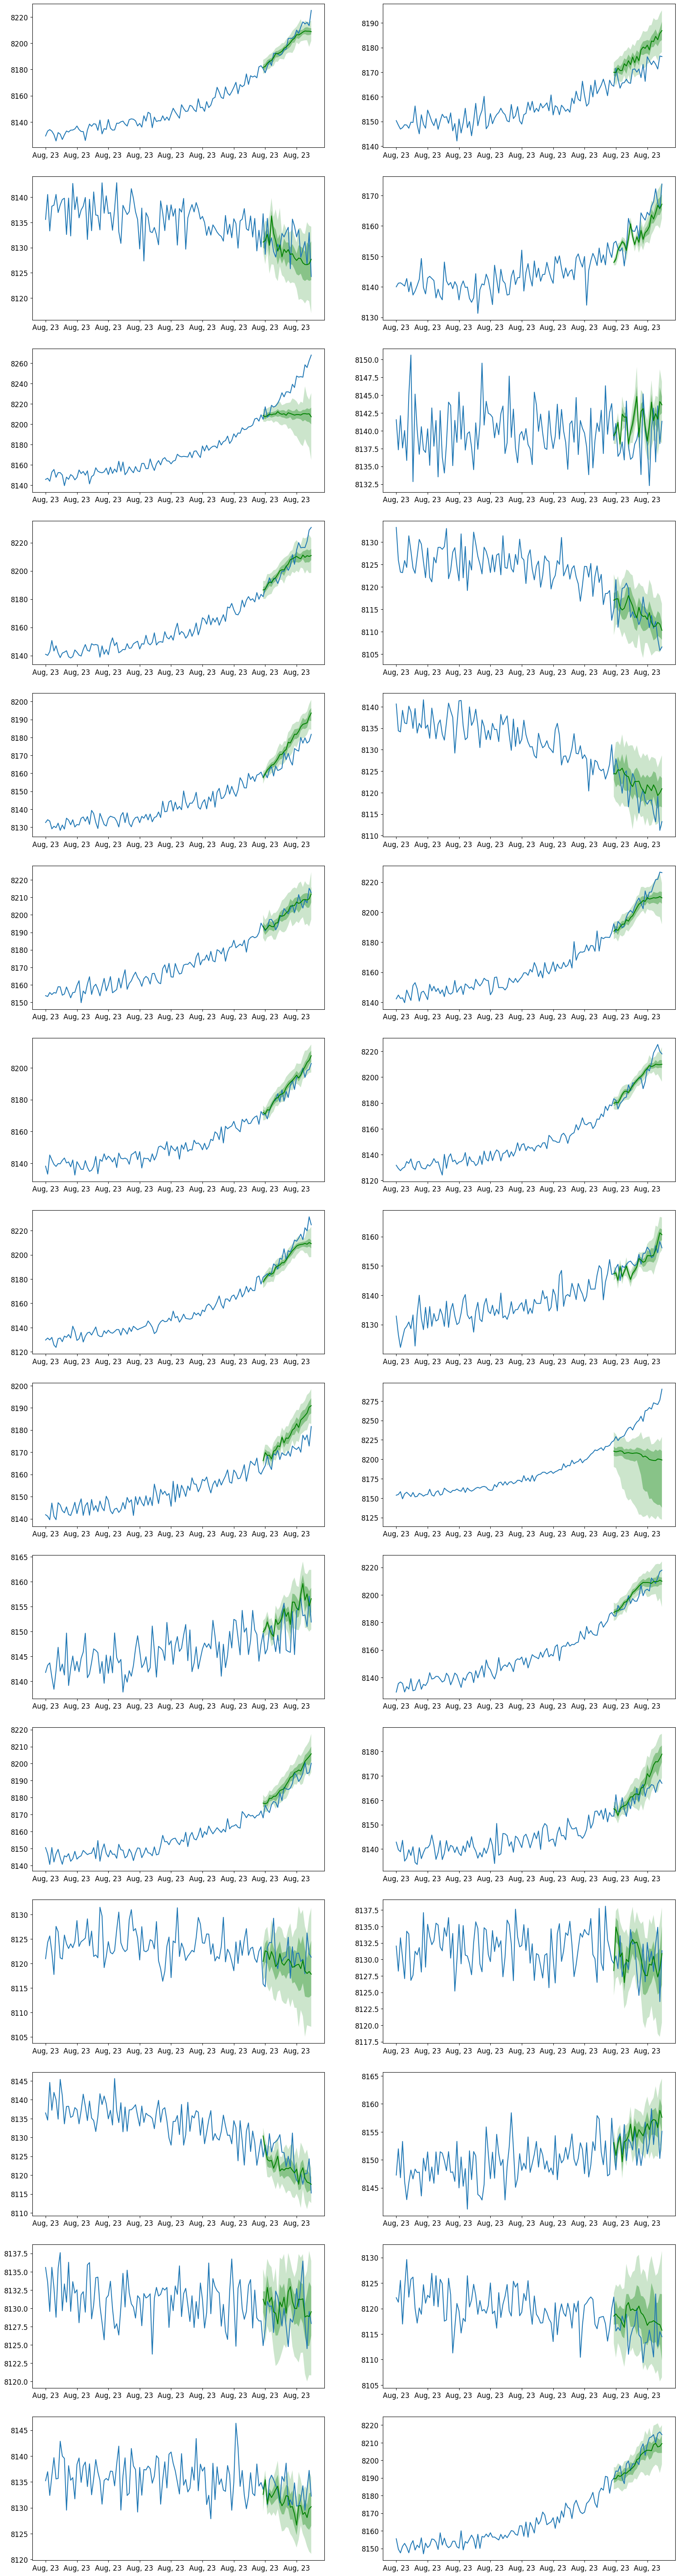

In [9]:
# manually standardised, scaling = 'robust'
forecasts, tss = inferenceStep(test_ds, test_df, predictor, mean, std, )

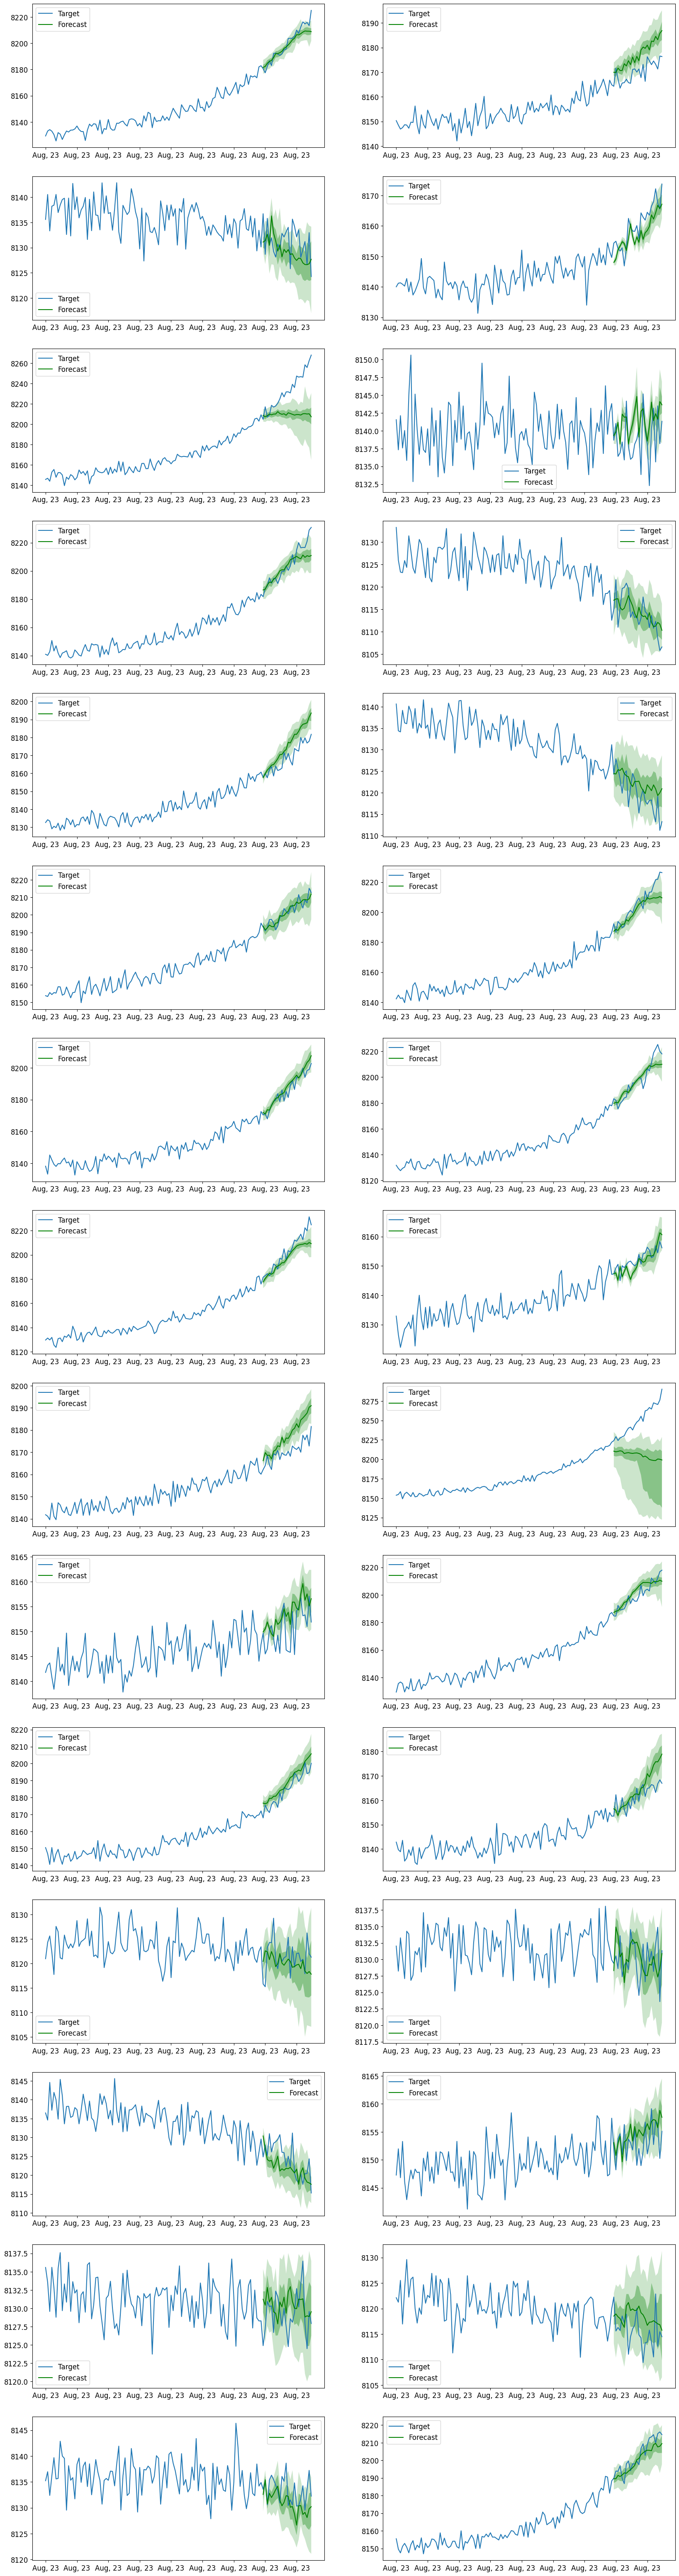

In [25]:
getPlot(forecasts, tss, )

In [14]:
CPRS, MASE, ND, IAE, Q_2 = getMetrics(forecasts, tss, test_ds, test_df, predictor, mean, std, )
print("CPRS: ", CPRS, "MASE: ", MASE, "ND: ", ND, "IAE-alpha: ", IAE, "Q_2: ", Q_2)

Running evaluation: 30it [00:00, 322.70it/s]


CPRS:  0.0006372631728829919 MASE:  1.757724986592959 ND:  0.0007426067484964452 IAE-alpha:  0.058750000000000004 Q_2:  [0.8588497701403428, -2.740622122744138, -0.6702733003424799, 0.5216340119547207, -1.9834311546493013, -0.7500943216620595, 0.7110938499392268, 0.3819769881288274, -0.1020943932000491, 0.05332073573674079, 0.8372680919280634, 0.6217875128574786, 0.8486753940566438, 0.7955496987300325, 0.6895886471891048, 0.06890301919234887, -2.067019641420307, -10.18572280725533, -0.417646370830445, 0.6976281839672598, 0.6725458367148254, -0.49283580878009814, -0.4643455360558708, -0.4575028213978187, -0.05963759053444195, -0.32217271395477676, -0.24750407643413852, -0.9094101974305704, -1.2032217349105423, 0.7065835014849744]
